In [ ]:
# Verify the Output, check that the alignment issue is fixed:

import polars as pl

# Load a processed file
df = pl.read_parquet('../data/processed/ml_ready/tail_number=672/flight_001.parquet')

print(f"Shape: {df.shape}")
print(f"Columns: {df.columns}")

# Check for NAs in ALT - should be minimal now
alt_na_pct = df['ALT'].null_count() / len(df) * 100
print(f"ALT NA %: {alt_na_pct:.2f}%")

# Verify time alignment
print(f"Duration: {df['time_sec'].max() / 60:.1f} minutes")
print(f"Sample rate: {len(df) / df['time_sec'].max():.1f} Hz")

In [ ]:
df.head()

# Setup and Configuration


In [9]:
import sys
sys.path.insert(0, '..')

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration
CONFIG = {
    'data_dir': Path('../data/processed/ml_ready'),
    'window_size': 256,      # 64 seconds at 4 Hz
    'stride': 64,            # 16 seconds stride (75% overlap)
    'batch_size': 64,
    'epochs': 50,
    'learning_rate': 1e-4,
    'latent_dim': 64,
    'n_heads': 4,
    'n_layers': 2,
    'dropout': 0.1,
    'train_split': 0.8,
}

# Engine + context signals
ENGINE_SIGNALS = ['N1_1', 'N1_2', 'N2_1', 'N2_2', 'EGT_1', 'EGT_2', 'FF_1', 'FF_2']
CONTEXT_SIGNALS = ['ALT', 'MACH', 'PTCH']
ALL_SIGNALS = ENGINE_SIGNALS + CONTEXT_SIGNALS

print(f"Signals: {len(ALL_SIGNALS)}")
print(f"Window: {CONFIG['window_size']} samples ({CONFIG['window_size']/4:.0f} sec)")


Using device: mps
Signals: 11
Window: 256 samples (64 sec)



# 2: Data Loading


In [10]:
def load_flight_data(data_dir: Path, signals: list, max_flights: int = None) -> list:
    """Load flight data from processed parquet files."""
    flights = []
    parquet_files = sorted(data_dir.glob('**/*.parquet'))

    if max_flights:
        parquet_files = parquet_files[:max_flights]

    for pq_file in tqdm(parquet_files, desc="Loading flights"):
        try:
            df = pl.read_parquet(pq_file)

            # Check if all signals exist
            missing = [s for s in signals if s not in df.columns]
            if missing:
                continue

            # Extract signals and drop NaNs
            data = df.select(signals).to_numpy()

            # Skip if too many NaNs
            nan_pct = np.isnan(data).sum() / data.size
            if nan_pct > 0.1:
                continue

            # Forward fill then backward fill remaining NaNs
            for i in range(data.shape[1]):
                mask = np.isnan(data[:, i])
                if mask.any():
                    # Forward fill
                    idx = np.where(~mask, np.arange(len(mask)), 0)
                    np.maximum.accumulate(idx, out=idx)
                    data[:, i] = data[idx, i]

            flights.append({
                'data': data.astype(np.float32),
                'file': pq_file.name,
                'tail': pq_file.parent.name.replace('tail_number=', ''),
            })
        except Exception as e:
            print(f"Error loading {pq_file}: {e}")

    print(f"Loaded {len(flights)} flights")
    return flights

# Load data (start with subset for testing)
flights = load_flight_data(CONFIG['data_dir'], ALL_SIGNALS, max_flights=5)


Loading flights: 100%|██████████| 5/5 [00:00<00:00, 29.91it/s]

Loaded 5 flights


# 3: Create Sequences


In [11]:

def create_sequences(flights: list, window_size: int, stride: int) -> np.ndarray:
    """Create overlapping sequences from flight data."""
    sequences = []
    sequence_metadata = []

    for flight in tqdm(flights, desc="Creating sequences"):
        data = flight['data']
        n_samples = len(data)

        for start in range(0, n_samples - window_size + 1, stride):
            seq = data[start:start + window_size]
            sequences.append(seq)
            sequence_metadata.append({
                'file': flight['file'],
                'tail': flight['tail'],
                'start_idx': start,
            })

    sequences = np.array(sequences)
    print(f"Created {len(sequences)} sequences, shape: {sequences.shape}")
    return sequences, sequence_metadata

sequences, seq_metadata = create_sequences(
    flights,
    CONFIG['window_size'],
    CONFIG['stride']
)


Creating sequences: 100%|██████████| 5/5 [00:00<00:00, 2942.96it/s]

Created 2038 sequences, shape: (2038, 256, 11)



# 4: Normalize and Split


In [12]:

# Fit scaler on training data only
n_train = int(len(sequences) * CONFIG['train_split'])
train_sequences = sequences[:n_train]
test_sequences = sequences[n_train:]

print(f"Train: {len(train_sequences)}, Test: {len(test_sequences)}")

# Fit scaler on training data (flatten to 2D for fitting)
scaler = StandardScaler()
train_flat = train_sequences.reshape(-1, train_sequences.shape[-1])
scaler.fit(train_flat)

# Transform both sets
def normalize_sequences(seqs, scaler):
    """Normalize sequences using fitted scaler."""
    original_shape = seqs.shape
    flat = seqs.reshape(-1, seqs.shape[-1])
    normalized = scaler.transform(flat)
    return normalized.reshape(original_shape).astype(np.float32)

train_normalized = normalize_sequences(train_sequences, scaler)
test_normalized = normalize_sequences(test_sequences, scaler)

print(f"Train mean: {train_normalized.mean():.4f}, std: {train_normalized.std():.4f}")
print(f"Test mean: {test_normalized.mean():.4f}, std: {test_normalized.std():.4f}")


Train: 1630, Test: 408
Train mean: 0.0000, std: 1.0000
Test mean: 0.1024, std: 0.8517



# 5: PyTorch Dataset


In [13]:

class FlightSequenceDataset(Dataset):
    def __init__(self, sequences: np.ndarray):
        self.sequences = torch.FloatTensor(sequences)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

train_dataset = FlightSequenceDataset(train_normalized)
test_dataset = FlightSequenceDataset(test_normalized)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")


Train batches: 26, Test batches: 7



# 6: Transformer Autoencoder Model


In [14]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class TransformerAutoencoder(nn.Module):
    def __init__(
        self,
        n_features: int,
        d_model: int = 64,
        n_heads: int = 4,
        n_layers: int = 2,
        dropout: float = 0.1,
        window_size: int = 256,
    ):
        super().__init__()

        self.n_features = n_features
        self.d_model = d_model

        # Input projection
        self.input_proj = nn.Linear(n_features, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, max_len=window_size)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Transformer decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True,
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)

        # Output projection
        self.output_proj = nn.Linear(d_model, n_features)

    def forward(self, x):
        # x shape: (batch, seq_len, n_features)

        # Encode
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        encoded = self.encoder(x)

        # Decode (using encoded as memory)
        decoded = self.decoder(x, encoded)

        # Project back to feature space
        output = self.output_proj(decoded)

        return output


# Initialize model
model = TransformerAutoencoder(
    n_features=len(ALL_SIGNALS),
    d_model=CONFIG['latent_dim'],
    n_heads=CONFIG['n_heads'],
    n_layers=CONFIG['n_layers'],
    dropout=CONFIG['dropout'],
    window_size=CONFIG['window_size'],
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(model)


Model parameters: 234,955
TransformerAutoencoder(
  (input_proj): Linear(in_features=11, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
    


# 7: Training Loop


In [15]:

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            total_loss += loss.item()

    return total_loss / len(loader)


# Training
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'])
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

train_losses = []
test_losses = []

for epoch in range(CONFIG['epochs']):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    scheduler.step(test_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{CONFIG['epochs']}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")

print("Training complete!")


Epoch 5/50: Train Loss: 0.129621, Test Loss: 0.078519
Epoch 10/50: Train Loss: 0.075153, Test Loss: 0.046837
Epoch 15/50: Train Loss: 0.051924, Test Loss: 0.030899
Epoch 20/50: Train Loss: 0.038121, Test Loss: 0.022376
Epoch 25/50: Train Loss: 0.030290, Test Loss: 0.017228
Epoch 30/50: Train Loss: 0.025036, Test Loss: 0.013727
Epoch 35/50: Train Loss: 0.021136, Test Loss: 0.011000
Epoch 40/50: Train Loss: 0.017887, Test Loss: 0.009185
Epoch 45/50: Train Loss: 0.015348, Test Loss: 0.007867
Epoch 50/50: Train Loss: 0.013435, Test Loss: 0.006797
Training complete!



# 8: Plot Training Curves


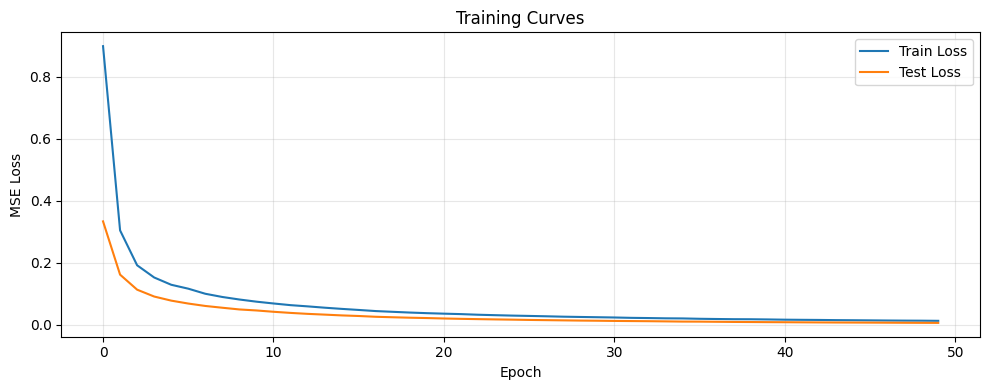

In [16]:

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train_losses, label='Train Loss')
ax.plot(test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Curves')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



# 9: Compute Anomaly Scores


In [17]:

def compute_anomaly_scores(model, loader, device):
    """Compute reconstruction error for each sequence."""
    model.eval()
    scores = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            output = model(batch)

            # MSE per sequence (mean over time and features)
            mse = ((output - batch) ** 2).mean(dim=(1, 2))
            scores.extend(mse.cpu().numpy())

    return np.array(scores)

train_scores = compute_anomaly_scores(model, train_loader, device)
test_scores = compute_anomaly_scores(model, test_loader, device)

print(f"Train scores - Mean: {train_scores.mean():.6f}, Std: {train_scores.std():.6f}")
print(f"Test scores - Mean: {test_scores.mean():.6f}, Std: {test_scores.std():.6f}")

# Set threshold (e.g., mean + 3*std from training)
threshold = train_scores.mean() + 3 * train_scores.std()
print(f"Anomaly threshold: {threshold:.6f}")

# Flag anomalies
train_anomalies = train_scores > threshold
test_anomalies = test_scores > threshold
print(f"Train anomalies: {train_anomalies.sum()} ({train_anomalies.mean()*100:.2f}%)")
print(f"Test anomalies: {test_anomalies.sum()} ({test_anomalies.mean()*100:.2f}%)")


Train scores - Mean: 0.006492, Std: 0.016114
Test scores - Mean: 0.006419, Std: 0.011535
Anomaly threshold: 0.054833
Train anomalies: 39 (2.39%)
Test anomalies: 5 (1.23%)



# 10: Visualize Anomaly Score Distribution


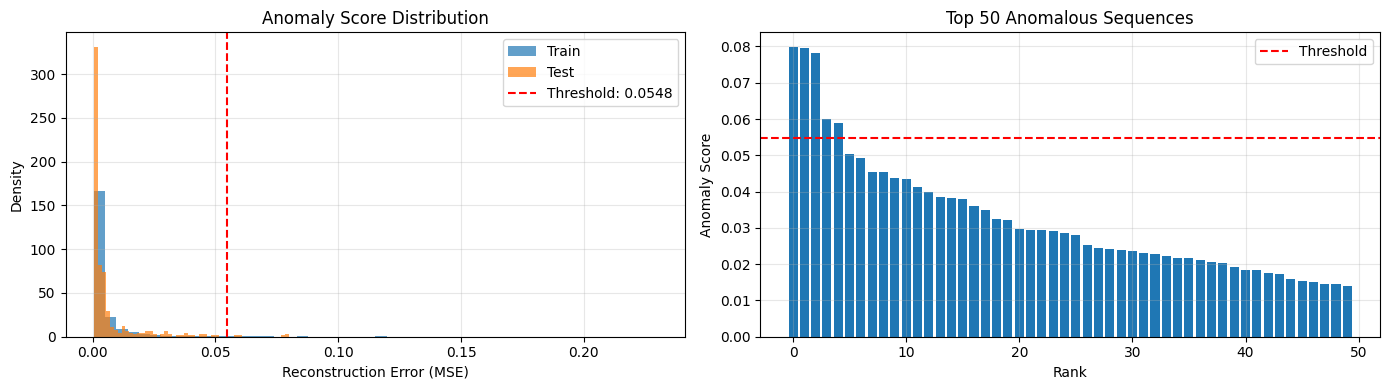

In [18]:

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram
ax1 = axes[0]
ax1.hist(train_scores, bins=50, alpha=0.7, label='Train', density=True)
ax1.hist(test_scores, bins=50, alpha=0.7, label='Test', density=True)
ax1.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
ax1.set_xlabel('Reconstruction Error (MSE)')
ax1.set_ylabel('Density')
ax1.set_title('Anomaly Score Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Top anomalies
ax2 = axes[1]
top_k = 50
top_indices = np.argsort(test_scores)[-top_k:][::-1]
ax2.bar(range(top_k), test_scores[top_indices])
ax2.axhline(threshold, color='red', linestyle='--', label='Threshold')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Anomaly Score')
ax2.set_title(f'Top {top_k} Anomalous Sequences')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# 11: Inspect Top Anomalies


Top anomaly - Score: 0.079890
Metadata: {'file': 'flight_005.parquet', 'tail': '672', 'start_idx': 4032}


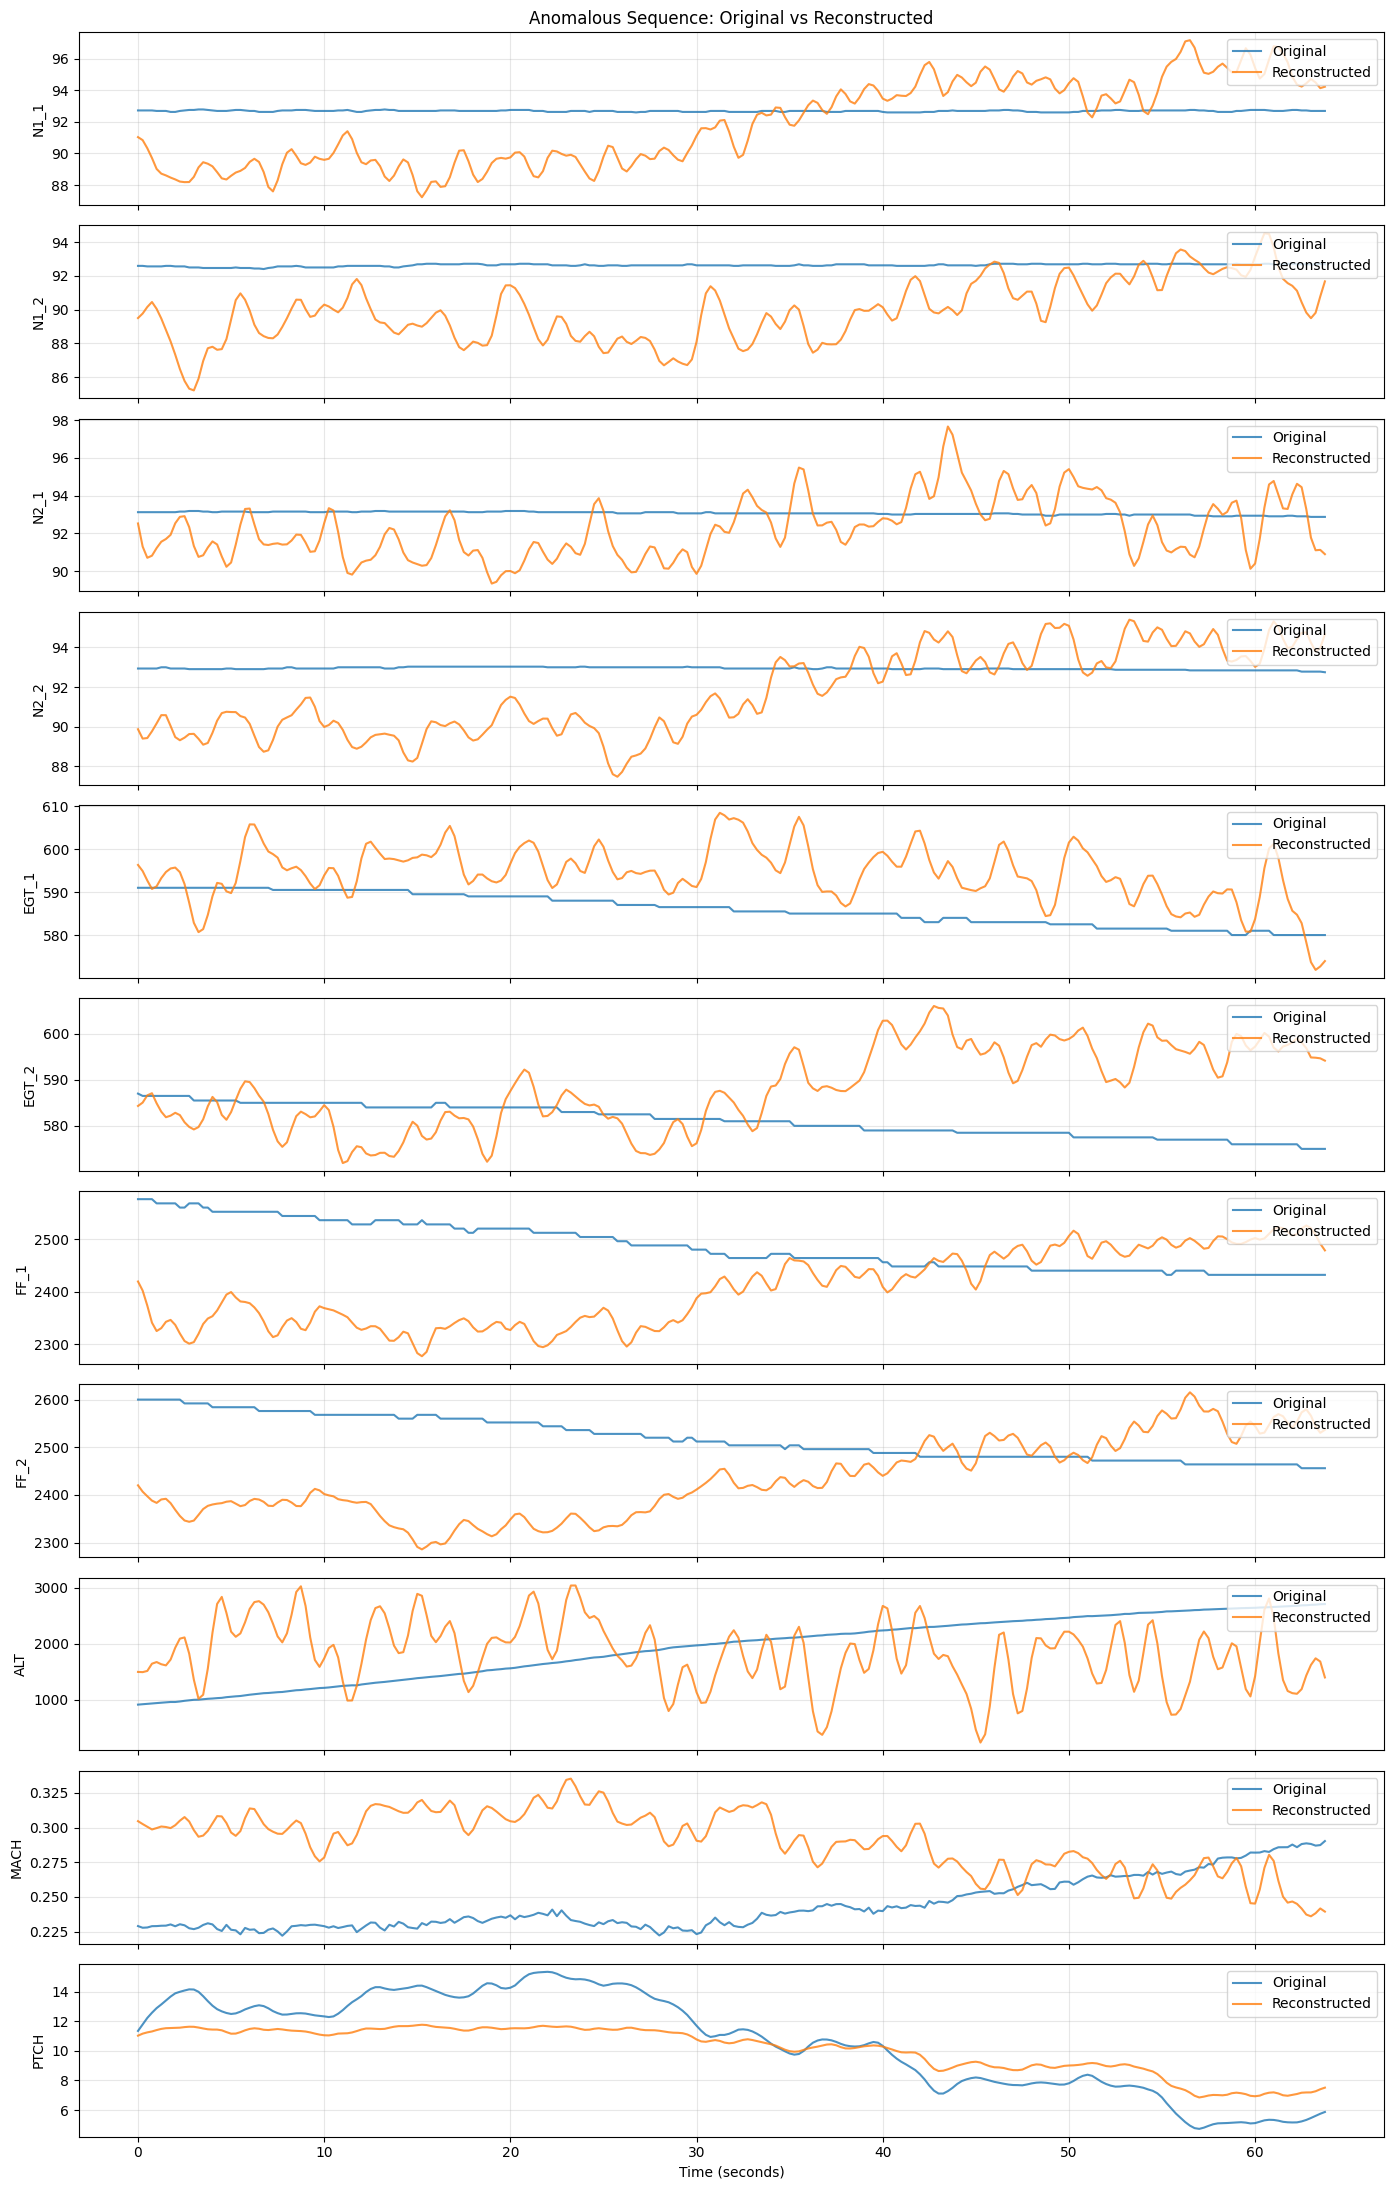

In [19]:

def plot_anomaly(model, sequence, scaler, signals, device):
    """Plot original vs reconstructed for an anomalous sequence."""
    model.eval()

    with torch.no_grad():
        seq_tensor = torch.FloatTensor(sequence).unsqueeze(0).to(device)
        reconstructed = model(seq_tensor).cpu().numpy()[0]

    # Denormalize for interpretability
    original_denorm = scaler.inverse_transform(sequence)
    recon_denorm = scaler.inverse_transform(reconstructed)

    n_signals = len(signals)
    fig, axes = plt.subplots(n_signals, 1, figsize=(14, 2*n_signals), sharex=True)

    time = np.arange(len(sequence)) / 4  # Convert to seconds

    for i, (ax, signal) in enumerate(zip(axes, signals)):
        ax.plot(time, original_denorm[:, i], label='Original', alpha=0.8)
        ax.plot(time, recon_denorm[:, i], label='Reconstructed', alpha=0.8)
        ax.set_ylabel(signal)
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel('Time (seconds)')
    axes[0].set_title('Anomalous Sequence: Original vs Reconstructed')

    plt.tight_layout()
    plt.show()

# Plot top anomaly
top_anomaly_idx = np.argmax(test_scores)
print(f"Top anomaly - Score: {test_scores[top_anomaly_idx]:.6f}")
print(f"Metadata: {seq_metadata[n_train + top_anomaly_idx]}")

plot_anomaly(model, test_normalized[top_anomaly_idx], scaler, ALL_SIGNALS, device)



# 12: Save Model


In [20]:

# Save model and scaler
torch.save({
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'signals': ALL_SIGNALS,
    'threshold': threshold,
    'train_scores_mean': train_scores.mean(),
    'train_scores_std': train_scores.std(),
}, '../models/engine_anomaly_detector.pt')

import joblib
joblib.dump(scaler, '../models/engine_scaler_5.pkl')

print("Model saved!")

Model saved!
